# Atividade Avaliativa N3 - Pipeline (Ciência de Dados)

Henrique de Castilhos

## Detecção de tweets spam

O dataset utilizado consiste em uma coleção de tweets, utilizando ele, será criado um detector de tweets spam.

In [ ]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


sns.set_style("darkgrid")
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")


In [ ]:
train_data.head()


,Id,Tweet,following,followers,actions,is_retweet,location,Type
0,10091,It's the everything else that's complicated. #...,0.0,11500.0,NaN,0.0,Chicago,Quality
1,10172,Eren sent a glare towards Mikasa then nodded a...,0.0,0.0,NaN,0.0,NaN,Quality
2,7012,I posted a new photo to Facebook http://fb.me/...,0.0,0.0,NaN,0.0,"Scotland, U.K",Quality
3,3697,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,3319.0,611.0,294.0,0.0,"Atlanta, Ga",Spam
4,10740,Pedophile Anthony Weiner is TERRIFIED of Getti...,4840.0,1724.0,1522.0,0.0,Blumberg,Spam


In [ ]:
test_data.head()


,Id,Tweet,following,followers,actions,is_retweet,location
0,0,Obama Criminal Enterprise Collapsing https://...,10.0,4,1214.0,0,Nairobi
1,1,I only learned to dream in sound #love,63.0,55,508.0,0,england
2,2,Cause I ain't trying to out here thinking you ...,0.0,0,0.0,0,NaN
3,3,When will they get that it's about #Liberty ? ...,2310.0,2736,32188.0,1,The Snow Forest
4,4,GM UAW workers to receive profit-sharing up to...,696.0,176,713.0,1,510502


Os conjuntos de dados de treinamento e teste contêm os tweets em si, quantidade de contas seguidas e seguidores do Twitter que postou o tweet, quatidade de ações (curtidas, respostas e retweets), indicação se é um retweet e a localização da conta. Porém, esses dados não estão padronizados.

O dataset de treino também tem a coluna `Type`, com a indicação se o tweet é ou não spam.

Vamos agora converter os valores da coluna `Type` para processamento futuro, para isso criaremos a coluna `is_spam` com valores 0 e 1.

In [ ]:
train_data["is_spam"] = np.where(train_data["Type"] == "Spam", 1, 0)


In [ ]:
train_data.info()
train_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11968 entries, 0 to 11967
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          11968 non-null  int64  
 1   Tweet       11968 non-null  object 
 2   following   11823 non-null  float64
 3   followers   11952 non-null  float64
 4   actions     9195 non-null   float64
 5   is_retweet  11967 non-null  float64
 6   location    10317 non-null  object 
 7   Type        11968 non-null  object 
 8   is_spam     11968 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 841.6+ KB


,Id,following,followers,actions,is_retweet,is_spam
count,11968.000000,1.182300e+04,1.195200e+04,9195.000000,11967.000000,11968.000000
mean,6292.273730,4.787110e+03,3.668763e+05,7314.563893,0.223949,0.485879
std,3632.510153,3.158289e+04,3.973314e+06,16468.215132,0.416906,0.499821
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,3150.750000,0.000000e+00,0.000000e+00,10.000000,0.000000,0.000000
50%,6289.500000,5.100000e+01,8.415000e+02,1487.000000,0.000000,0.000000
75%,9442.250000,3.635000e+03,1.328775e+04,7265.500000,0.000000,1.000000
max,12598.000000,1.600000e+06,1.050000e+08,165865.000000,1.000000,1.000000


In [ ]:
print("Porcentagem de tweets normais: {:.2f}%".format(
    sum(train_data["is_spam"] == 0) / len(train_data["is_spam"]) * 100))
print("Porcentagem de tweets spam: {:.2f}%".format(
    sum(train_data["is_spam"] == 1) / len(train_data["is_spam"]) * 100))


Porcentagem de tweets normais: 51.41%
Porcentagem de tweets spam: 48.59%


Podemos visualizar que os dados de treinamento estão bem equilibrados, o que facilitará o processo de treinamento.

Vamos agora examinar o dataset de teste para ver existe algo desorganizado nele.

In [ ]:
test_data.info()
test_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          630 non-null    int64  
 1   Tweet       630 non-null    object 
 2   following   623 non-null    float64
 3   followers   630 non-null    int64  
 4   actions     483 non-null    float64
 5   is_retweet  630 non-null    int64  
 6   location    550 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ KB


,Id,following,followers,actions,is_retweet
count,630.000000,623.000000,6.300000e+02,483.000000,630.000000
mean,314.500000,3769.285714,1.747354e+05,7053.770186,0.215873
std,182.009615,19341.328122,1.625310e+06,16849.853069,0.411754
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,157.250000,0.000000,0.000000e+00,6.000000,0.000000
50%,314.500000,3.000000,6.580000e+02,1310.000000,0.000000
75%,471.750000,2921.000000,1.259950e+04,5762.500000,0.000000
max,629.000000,414000.000000,3.000000e+07,160853.000000,1.000000


Em seguida, podemos pegar dados adicionais sobre os tweets:

- Tamanho do tweet (quantidade de caracteres)
- Hashtags usadas e sua quantidade
- Menção há outras contas e sua quantidade
- Números/Dígitos utilizados
- Links usados

Existem algumas suposições por trás desses indicadores adicionais. Em relação ao tamanho do tweet, tweets de spam tendem a ser mais curtos, o uso excessivo de hashtags e menções a outros usuários também são outros indicativos.

No entanto precisamos validar se essas suposições são reais ou falsas.

In [ ]:
def tweet_len(df):
    df["tweet_len"] = df["Tweet"].str.len()
    return df


def extract_hashtags(df):
    df["hashtags"] = df["Tweet"].str.findall(r"\#\w+\b")
    df["hashtags_count"] = df["hashtags"].str.len()
    df["hashtags"] = df["hashtags"].str.join(" ")
    return df


def extract_mentions(df):
    df["mentions"] = df["Tweet"].str.findall(r"\@\w+\b")
    df["mentions_count"] = df["mentions"].str.len()
    df["mentions"] = df["mentions"].str.join(" ")
    return df


def extract_digits(df):
    df["digits"] = df["Tweet"].str.findall(r"\d+")
    df["digits_count"] = df["digits"].str.len()
    df["digits"] = df["digits"].str.join(" ")
    df["digits_len"] = df["digits"].str.len()
    return df


def extract_links(df):
    df["links"] = df["Tweet"].str.findall(
        r"((?:(?:\w+)\.twitter\.com\/(?:\w+|)|https?://)(?:\w|\.|\/|\-|\#|\=|\?|\_|\&|\%)+\b)")
    df["links_count"] = df["links"].str.len()
    df["links"] = df["links"].str.join(" ")
    df["domain_names"] = df["links"].str.findall(r"\w+\.\w+(?:\.\w+|)")
    df["domain_names"] = df["domain_names"].str.join(" ")
    return df


In [ ]:
def replace_nan(df, value):
    df.fillna(value=value, inplace=True)
    return df


In [ ]:
datasets = [train_data, test_data]

for df in datasets:
    tweet_len(df)
    extract_hashtags(df)
    extract_mentions(df)
    extract_digits(df)
    extract_links(df)
    replace_nan(df, value=-1)


In [ ]:
train_data[["Tweet", "tweet_len", "hashtags", "hashtags_count", "mentions", "mentions_count",
            "digits", "digits_count", "digits_len", "links", "links_count", "domain_names"]].head()


,Tweet,tweet_len,hashtags,hashtags_count,mentions,mentions_count,digits,digits_count,digits_len,links,links_count,domain_names
0,It's the everything else that's complicated. #...,84,#PESummit #PXpic,2,,0,6,1,1,PXpic.twitter.com/Jsv6BAFQMl,1,PXpic.twitter.com
1,Eren sent a glare towards Mikasa then nodded a...,139,,0,@SincerePyrrhic,1,,0,0,,0,
2,I posted a new photo to Facebook http://fb.me/...,55,,0,,0,2 7,2,3,http://fb.me/2Be7LiyuJ,1,fb.me
3,#jan Idiot Chelsea Handler Diagnoses Trump Wit...,105,#jan,1,,0,8 35,2,4,https://t.co/k8PrqcWTRI https://t.co/dRN35xtSJZ,2,t.co t.co
4,Pedophile Anthony Weiner is TERRIFIED of Getti...,92,,0,,0,3 9 4,3,5,https://t.co/g3bU9Q4gAg,1,t.co


In [ ]:
test_data[["Tweet", "tweet_len", "hashtags", "hashtags_count", "mentions", "mentions_count",
           "digits", "digits_count", "digits_len", "links", "links_count", "domain_names"]].head()


,Tweet,tweet_len,hashtags,hashtags_count,mentions,mentions_count,digits,digits_count,digits_len,links,links_count,domain_names
0,Obama Criminal Enterprise Collapsing https://...,128,#TCOT #MAGA #PJNET,3,,0,3 8 1,3,5,https://t.co/zIWjkQNMkh https://t.co/3gkxKiCqg...,3,t.co t.co t.co
1,I only learned to dream in sound #love,39,#love,1,,0,,0,0,,0,
2,Cause I ain't trying to out here thinking you ...,50,,0,,0,,0,0,,0,
3,When will they get that it's about #Liberty ? ...,85,#Liberty #pineapplepizza,2,,0,98,1,2,https://t.co/XrKFyKe98M,1,t.co
4,GM UAW workers to receive profit-sharing up to...,78,,0,,0,11 000 3 0,4,10,https://t.co/EKGpUl3w0u,1,t.co


A matriz de correlação pode fornecer algumas informações sobre como diferentes recursos dependem (ou não) uns dos outros e se existe alguma dependência entre esses recursos e o tipo de tweet.

Text(0.5, 1.0, 'Matriz de correlação entre características dos tweets e sua qualidade')

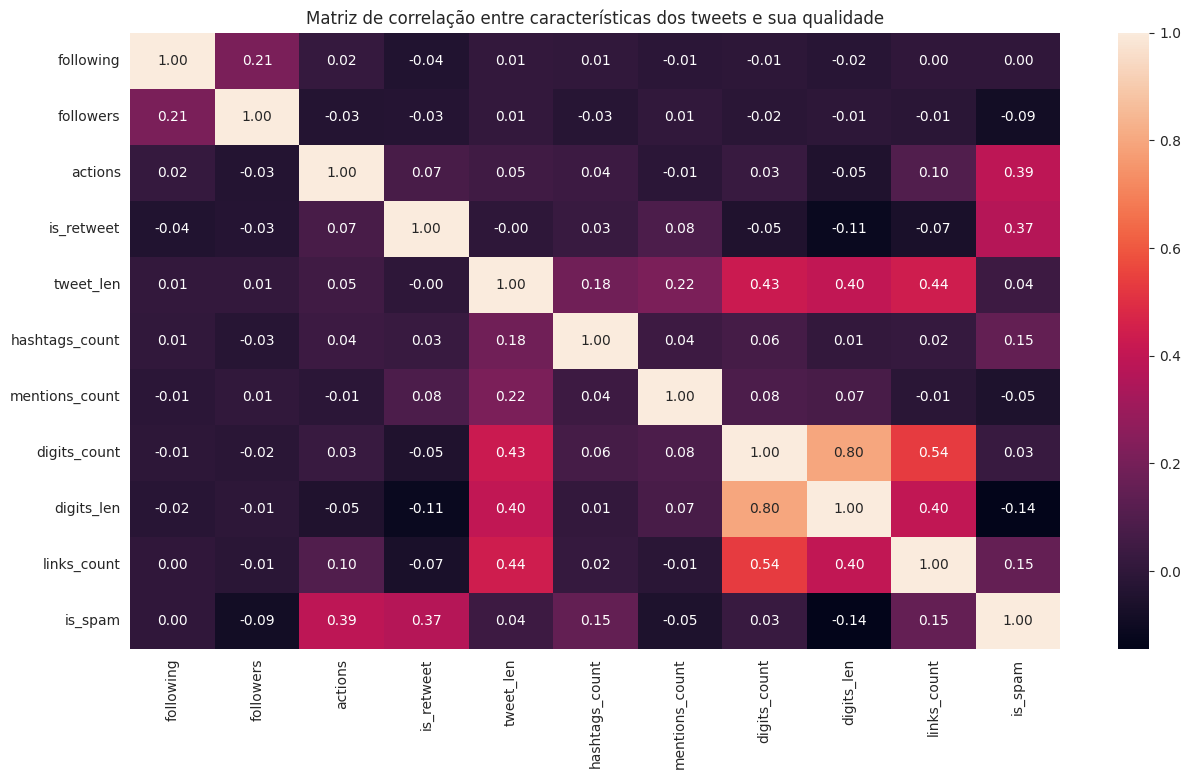

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_data[["following", "followers", "actions", "is_retweet", "tweet_len", "hashtags_count", "mentions_count", "digits_count", "digits_len",
            "links_count", "is_spam"]].corr(), annot=True, fmt=".2f").set_title("Matriz de correlação entre características dos tweets e sua qualidade")


A julgar pela matriz de correlação, se um tweet for caracterizado por muitas ações, ou se for um retweet, há mais chances desse (re)tweet ser spam.

Número de tweets: 9287
Número de retweets: 2680
Número de retweets spam: 2222
Número de retweets não spam: 458


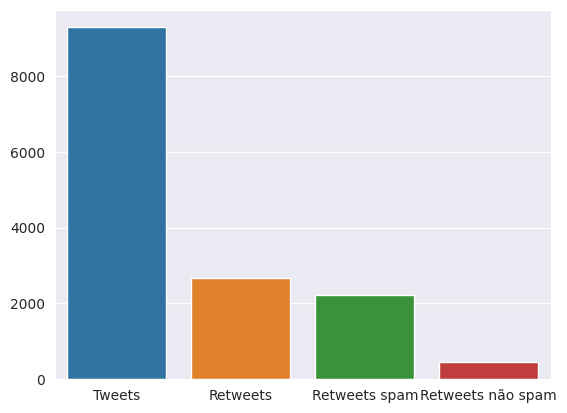

In [ ]:
tweets = train_data[train_data["is_retweet"] == 0].copy()
retweets = train_data[train_data["is_retweet"] == 1].copy()

print("Número de tweets: {}".format(len(tweets)))
print("Número de retweets: {}".format(len(retweets)))

print('Número de retweets spam: {}'.format(sum(retweets["is_spam"] == 1)))
print('Número de retweets não spam: {}'.format(sum(retweets["is_spam"] == 0)))

retweets_stat = pd.Series(data={'Tweets': len(tweets),
                                'Retweets': len(retweets),
                                'Retweets spam': sum(retweets['is_spam'] == 1),
                                'Retweets não spam': sum(retweets['is_spam'] == 0)})

sns.barplot(x=retweets_stat.index, y=retweets_stat)


Como pode ser visto, a maioria dos retweets foram marcados como spam no conjunto de dados de treinamento. Mas também é importante considerar que a quantidade de retweets é aproximadamente 3x menor que a quantidade de tweets.

In [ ]:
spam_train = train_data[train_data["is_spam"] == 1].copy()
non_spam_train = train_data[train_data["is_spam"] == 0].copy()


In [ ]:
cols = ["hashtags_count", "mentions_count", "links_count"]

print("Tweets não spam:")
for col in cols:
    print("Média de {} é {:.2f}".format(col.replace(
        "_count", ""), non_spam_train[col].mean()))

print("\nTweets spam:")
for col in cols:
    print("Média de {} é {:.2f}".format(
        col.replace("_count", ""), spam_train[col].mean()))


Tweets não spam:
Média de hashtags é 0.44
Média de mentions é 0.27
Média de links é 0.69

Tweets spam:
Média de hashtags é 0.75
Média de mentions é 0.19
Média de links é 0.92


Não há uma diferença muito significativa, mas podemos ver que em tweets spam costumam ter uma quantidade maior de hashtags e links.

In [ ]:
def most_frequent(df, vocab):
    words = []
    for data in df[vocab]:
        words.extend(str(data).lower().split())

    fdist = nltk.FreqDist(words)

    most_frequent = []

    if vocab == 'Tweet':
        most_frequent = [w for w in fdist if w.isalpha() and len(
            w) > 5 and fdist[w] > 50]
    else:
        most_frequent = [w for w in fdist if fdist[w] > 15]

    frequency = []
    for word in most_frequent:
        frequency.append(fdist[word])

    sns.barplot(x=frequency, y=most_frequent)


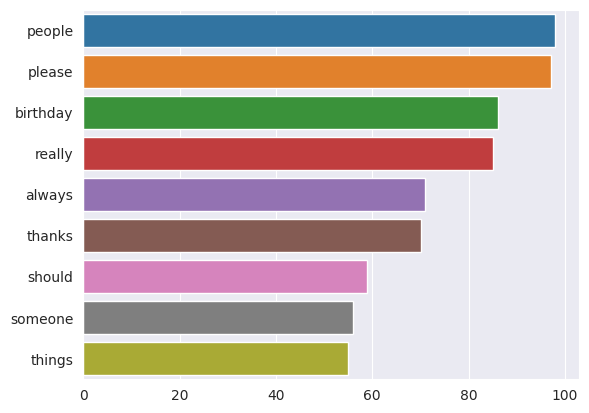

In [ ]:
most_frequent(non_spam_train, vocab="Tweet")


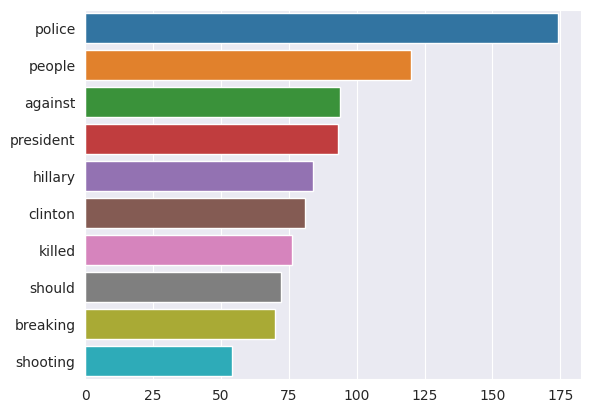

In [ ]:
most_frequent(spam_train, vocab="Tweet")


É possível notar que os principais tópicos nos tweets spam são política e crime. Para os normais, é difícil determinar.

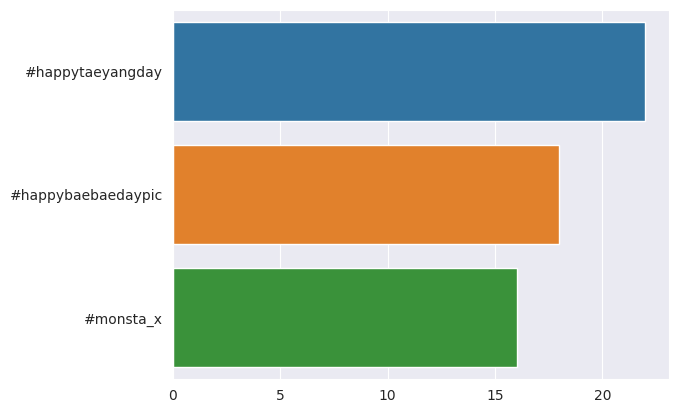

In [ ]:
most_frequent(non_spam_train, vocab="hashtags")


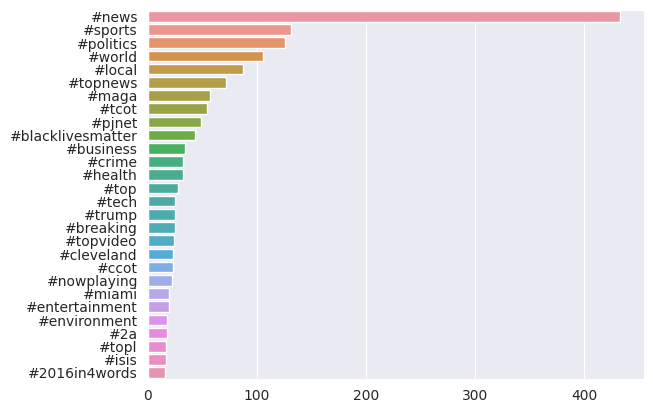

In [ ]:
most_frequent(spam_train, vocab="hashtags")


As hashtags mais frequentes nos tweets não spam são relacionadas à música k-pop, enquanto as mais frequentes em spam são relacionadas a notícias.

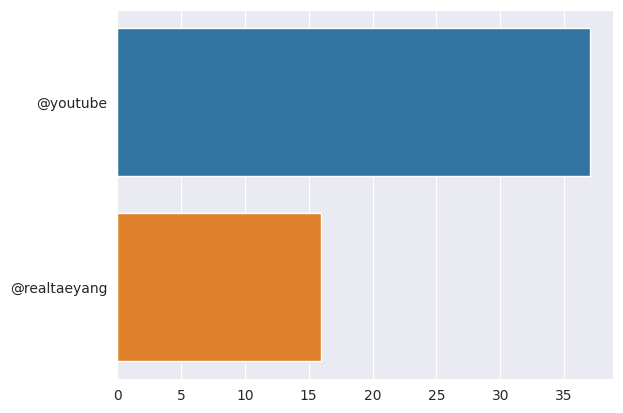

In [ ]:
most_frequent(non_spam_train, vocab="mentions")


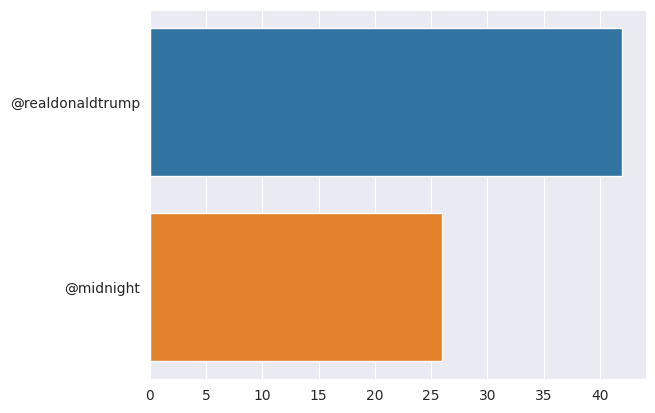

In [ ]:
most_frequent(spam_train, vocab="mentions")


Nos tweets não spam a maioria das menções são ao YouTube e a um cantor de k-pop. Por sua vez nos tweets spam são figuras e portais de notícias políticas.

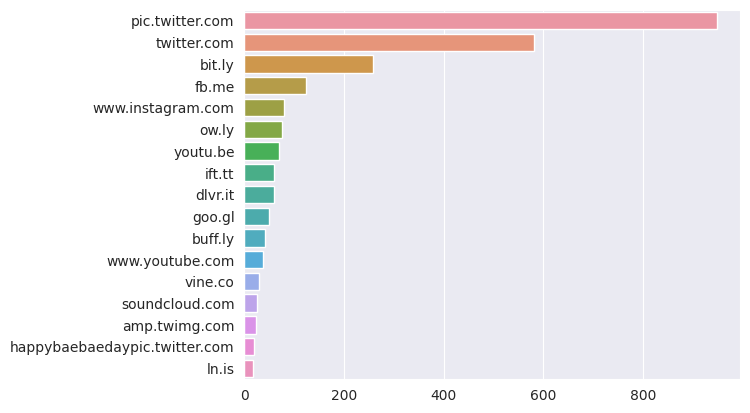

In [ ]:
most_frequent(non_spam_train, vocab="domain_names")


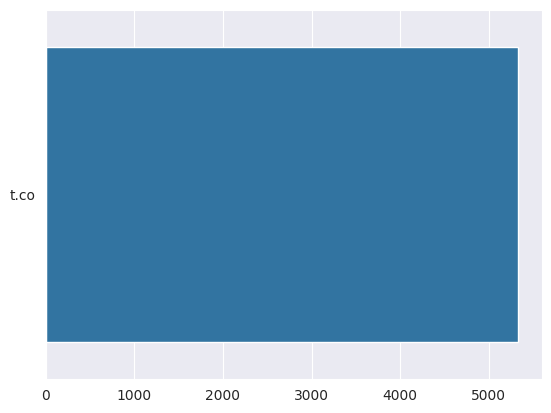

In [ ]:
most_frequent(spam_train, vocab="domain_names")


Agora chegamos em um ponto importante, tweets não spam têm uma variedade de sites sendo compartilhados, enquanto nos de spam o domínio mais frequente é "t.co". Vamos checar quantas instâncias deste site estão no conjunto de dados regulares.

In [ ]:
print('De {} tweets, {} contém o domínio "t.co"'.format(len(non_spam_train["domain_names"]), len(
    non_spam_train[non_spam_train["domain_names"].str.contains("t.co")])))


De 6153 tweets, 61 contém o domínio "t.co"


Porém "t.co" é um domínio do Twitter e não um sinal de uma mensagem de spam em si.

Abaixo estão as nuvens de palavras - visualizações das palavras mais frequentes usadas nos tweets e os locais mais frequentes indicados nas contas do Twitter no dataset de treino.

In [ ]:
def show_wordcloud(df, vocab):
    words = []
    for text in df[vocab]:
        word = str(text).lower().split()
        words.extend(word)

    all_words = ' '.join(words)

    # Remover os links
    all_words = re.sub(
        'https?://(\w|\d|\.|\/|\-|\#|\=|\?|\_|\&|\%)+\s', '', all_words)
    all_words = re.sub('(?:(?:\w+)\.twitter\.com\/(?:\w+|))', '', all_words)

    wordcloud = WordCloud(colormap='plasma').generate(all_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


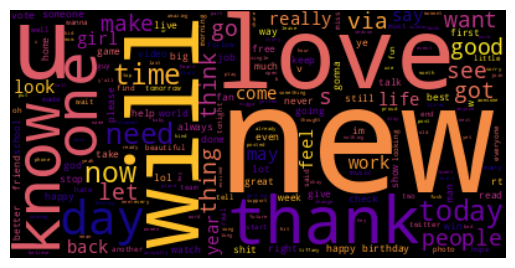

In [ ]:
show_wordcloud(df=non_spam_train, vocab='Tweet')


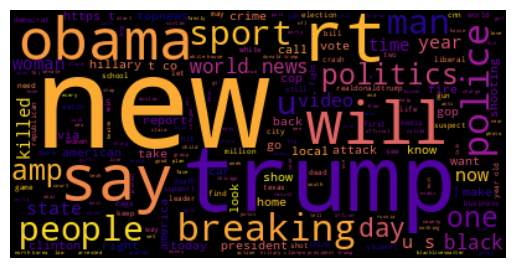

In [ ]:
show_wordcloud(df=spam_train, vocab='Tweet')


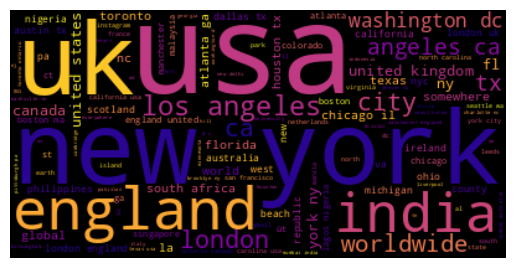

In [ ]:
show_wordcloud(df=non_spam_train, vocab='location')


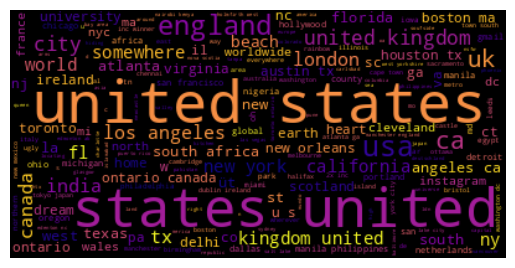

In [ ]:
show_wordcloud(df=spam_train, vocab='location')


Podemos também checar quais tópicos de discussão podem ser derivados dos tweets, conseguimos fazer isso utilizando LDA (Latent Dirichlet Allocation)

In [ ]:
def get_discussion_topics(df, topics_quant):
    words = []
    for data in df['Tweet']:
        words.extend(str(data).lower().split())

    exclude_words = stopwords.words('english')

    words = [w for w in words if w.isalpha() and len(
        w) > 5 and w not in exclude_words]

    tf_idf_vectorizer = TfidfVectorizer()
    tf_idf_arr = tf_idf_vectorizer.fit_transform(words)
    vocab_tf_idf = tf_idf_vectorizer.get_feature_names_out()

    lda_model = LatentDirichletAllocation(
        n_components=topics_quant, max_iter=20, random_state=12)
    X_topics = lda_model.fit_transform(tf_idf_arr)
    topic_words = lda_model.components_

    for i, topic_dist in enumerate(topic_words):
        sorted_topic_dist = np.argsort(topic_dist)
        detected_topics = np.array(vocab_tf_idf)[sorted_topic_dist]
        detected_topics = detected_topics[:-11:-1]
        print("Detected tweets' topic {}:".format(i+1))
        print(detected_topics)


In [ ]:
get_discussion_topics(df=non_spam_train, topics_quant=5)


Detected tweets' topic 1:
['birthday' 'someone' 'posted' 'something' 'actually' 'tomorrow' 'support'
 'pretty' 'remember' 'students']
Detected tweets' topic 2:
['people' 'thanks' 'beautiful' 'tiffany' 'excited' 'believe' 'change'
 'thought' 'international' 'nothing']
Detected tweets' topic 3:
['things' 'looking' 'getting' 'everyone' 'coming' 'single' 'follow'
 'already' 'making' 'summer']
Detected tweets' topic 4:
['please' 'really' 'better' 'another' 'amazing' 'everything' 'around'
 'facebook' 'social' 'finally']
Detected tweets' topic 5:
['always' 'school' 'little' 'morning' 'person' 'listen' 'anyone' 'tonight'
 'united' 'online']


In [ ]:
get_discussion_topics(df=spam_train, topics_quant=5)


Detected tweets' topic 1:
['police' 'killed' 'breaking' 'shooting' 'america' 'russia' 'former'
 'suspect' 'attack' 'chicago']
Detected tweets' topic 2:
['people' 'another' 'liberals' 'islamic' 'campaign' 'military' 'senate'
 'students' 'nothing' 'leader']
Detected tweets' topic 3:
['trumps' 'american' 'arrested' 'report' 'charged' 'national' 'washington'
 'family' 'claims' 'better']
Detected tweets' topic 4:
['president' 'hillary' 'donald' 'million' 'support' 'accused' 'americans'
 'racist' 'security' 'liberal']
Detected tweets' topic 5:
['clinton' 'county' 'school' 'democrats' 'election' 'weekend' 'injured'
 'political' 'muslim' 'lawsuit']


Como na análise das palavras mais frequentes, parece que os tweets de spam são focados principalmente em tópicos políticos, enquanto os não spam são mais diversos e focados em tópicos como a vida cotidiana.

Agora com as informações adicionais extraídas e analisadas, podemos seguir com a modelagem do detector de spam.

In [ ]:
def apply_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    target_names = ['Spam', 'Quality']

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)

    print('Modelo: {}'.format(model))
    print('A pontuação de precisão é %0.4f' % accuracy)
    print('A pontuação ROC-AUC é %0.4f' % roc_auc)


Vamos seguir com uma abordagem mais simples e ver se os indicadores, derivados do dataset original, podem ser úteis para prever se o tweet é spam.

In [ ]:
features = ["following", "followers", "actions", "is_retweet", "tweet_len",
            "hashtags_count", "mentions_count", "digits_count", "digits_len", "links_count"]

x_train, x_test, y_train, y_test = train_test_split(
    train_data[features], train_data["is_spam"], random_state=42)


In [ ]:
models = [GaussianNB(), LogisticRegression(max_iter=1000),
          SVC(probability=True), RandomForestClassifier()]


In [ ]:
for model in models:
    apply_models(model, x_train, x_test, y_train, y_test)
    print()


Modelo: GaussianNB()
A pontuação de precisão é 0.5993
A pontuação ROC-AUC é 0.9912

Modelo: LogisticRegression(max_iter=1000)
A pontuação de precisão é 0.9703
A pontuação ROC-AUC é 0.9967

Modelo: SVC(probability=True)
A pontuação de precisão é 0.5548
A pontuação ROC-AUC é 0.8905

Modelo: RandomForestClassifier()
A pontuação de precisão é 0.9963
A pontuação ROC-AUC é 0.9999



Pelas pontuações, podemos concluir que o Random Forest Classifier apresenta os melhores resultados.

In [ ]:
rf = RandomForestClassifier()
rf.fit(train_data[features], train_data['is_spam'])
y_pred = rf.predict(test_data[features])


In [ ]:
y_pred


array([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,